# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
2
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset
from orbit_generation.model_factory import get_model
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.trainer import train_model

In [3]:
import numpy as np
import os

# Parameters

In [4]:
want_to_train = True        # Set this parameter to False if you want to load the model from the folder
want_to_generate = True     # Set this parameter to False if you want to load the generation from the folder
calculate_metrics = True    # Set this parameter to False if you don't want to calculate any metric

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 32,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0,
    'batch_size': 32,
    'epochs': 5,
    'beta': 1,
    'lr': 0.001,
    'dropout_rate': 0.1,
    'num_samples': 100
}

# Data

## Import

In [7]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

## Shuffle

In [8]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
shuffled_data = data[indices]
labels = np.array(labels)
shuffled_labels = labels[indices]

## Scaling

In [9]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(shuffled_data, dtype=torch.float64))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [10]:
model = get_model(params)

In [11]:
#| export
#| hide
import torch
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
from sklearn.model_selection import train_test_split



# Validate params keys with defaults
epochs = params.get('epochs', 10)  # Default to 10 if not specified
batch_size = params.get('batch_size', 32)  # Default batch size
val_split = params.get('val_split', 0.1)  # Default validation split

print(f"Configured epochs: {epochs}, batch_size: {batch_size}, val_split: {val_split}")

if not isinstance(data, torch.Tensor):
    print('no')
# Convert data to tensors if not already
data = torch.tensor(data, dtype=torch.float32) if not isinstance(data, torch.Tensor) else scaled_data
labels = torch.tensor(labels, dtype=torch.long) if not isinstance(labels, torch.Tensor) else labels

# Split the data and create dataloaders
if val_split > 0:
    X_train, X_val, y_train, y_val = train_test_split(
        data, labels,
        test_size=val_split,
        random_state=42
    )
    train_dataset = TensorDataset(X_train)
    val_dataset = TensorDataset(X_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=15)
else:
    X_train, y_train = data, labels
    val_dataloader = None

train_dataset = TensorDataset(X_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=15)

# Initialize PyTorch Lightning Trainer with GPU settings
trainer = Trainer(
    max_epochs=epochs,
    log_every_n_steps=10,
    devices="auto",  # Automatically use available GPUs
    accelerator="auto"  # Automatically select the best accelerator (GPU or CPU)
)

print("Starting training...")
# Train the model
if val_dataloader:
    trainer.fit(model, train_dataloader, val_dataloader)
else:
    trainer.fit(model, train_dataloader)

# Return metrics after training is complete
print("Training complete. Here are the metrics:")


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_

Configured epochs: 5, batch_size: 32, val_split: 0
no
Starting training...



  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | encoder | Conv5Encoder     | 3.5 M  | train
1 | decoder | Conv5Decoder     | 3.5 M  | train
2 | metrics | MetricCollection | 0      | train
-----------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.659    Total estimated model params size (MB)
53        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Training complete. Here are the metrics:


In [12]:
"""if want_to_train:
    # Initialize the model outside the function
    model = get_model(params)

    # Pass the model and training configuration to the function
    metrics = train_model(model, scaled_data, shuffled_labels, params)"""

'if want_to_train:\n    # Initialize the model outside the function\n    model = get_model(params)\n\n    # Pass the model and training configuration to the function\n    metrics = train_model(model, scaled_data, shuffled_labels, params)'

## Saving

In [13]:
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

JSONDecodeError: Expecting value: line 14 column 30 (char 354)

In [14]:
metrics = model.metrics
print(metrics)

MetricCollection(
  (kl_loss): MeanMetric()
  (reconstruction_loss): MeanMetric()
  (total_loss): MeanMetric()
)


In [15]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=metrics)

Metrics added to experiment with ID 6 in ../experiments/experiments.json.


In [16]:
# Define full paths for saving

generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_data.npy')
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_data.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_data.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
sampled_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_sampled_latent_representations.npy')
labels_latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_labels_latent_representations.npy')

In [17]:
if want_to_train:
    if params['model_name']=='vae_conv5':
        encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
        decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
        model.encoder.save(encoder_save_path, save_format='tf')
        model.decoder.save(decoder_save_path, save_format='tf')
    else:
        model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
        model.save(model_save_path, save_format='tf')
else:
    if params['model_name']=='vae_conv5':
        encoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_encoder')
        decoder_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_decoder')
        encoder = tf.keras.models.load_model(encoder_save_path)
        decoder = tf.keras.models.load_model(decoder_save_path)
        model = tsgm.models.cvae.BetaVAE(encoder, decoder)
    else:
        model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model')
        model = tf.keras.models.load_model(model_save_path)

INFO:tensorflow:Assets written to: ../experiments/experiment_6/exp6_encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_6/exp6_encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_6/exp6_decoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment_6/exp6_decoder/assets


## Generate

In [17]:
generation = model.generate(params['num_samples'])

In [15]:
if want_to_generate:
    # Generate the orbits
    generation = model.generate(params['num_samples'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation)
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

NameError: name 'generated_data_path' is not defined

# Analysis of Generation

## Visualization

In [29]:
if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:].cpu().numpy()
    generation.shape
else:
    no_time_generation = generation.cpu().numpy()

no_time_generation.shape

(100, 6, 100)

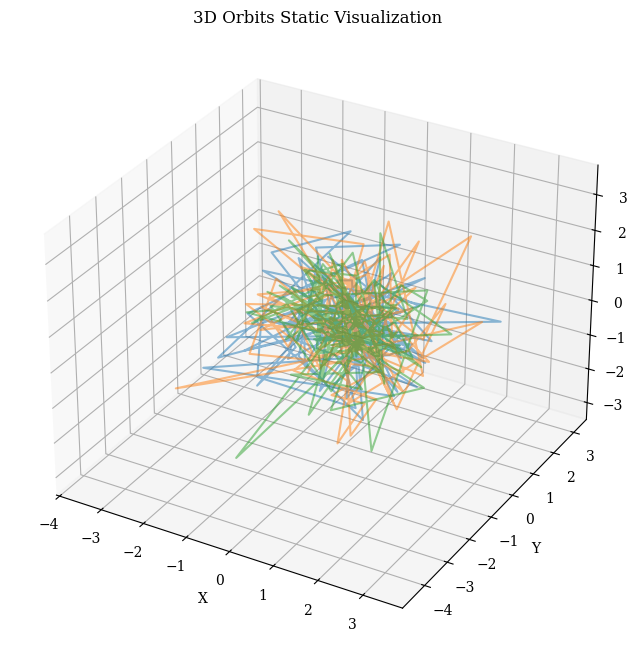

In [31]:
visualize_static_orbits(data= no_time_generation, show_legend=False, orbit_indices=[0,1,2])

In [21]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

NameError: name 'static_all_orbit_path' is not defined

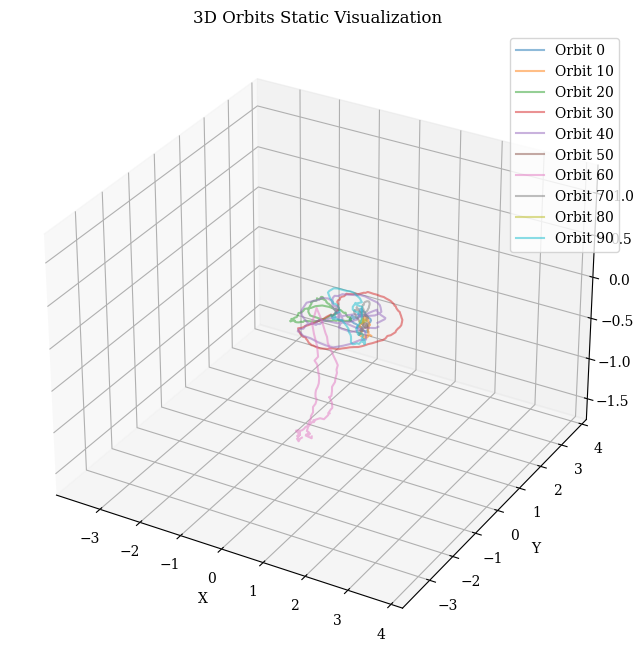

In [21]:
visualize_static_orbits(data= np.transpose(no_time_generation, (0, 2, 1)), orbit_indices=[0,10,20,30,40,50,60,70,80,90], save_path=static_some_orbit_path)

In [22]:
export_dynamic_orbits_html(data=np.transpose(no_time_generation, (0, 2, 1)), filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_6/images/exp6_generated_orbits.html


## Coverage

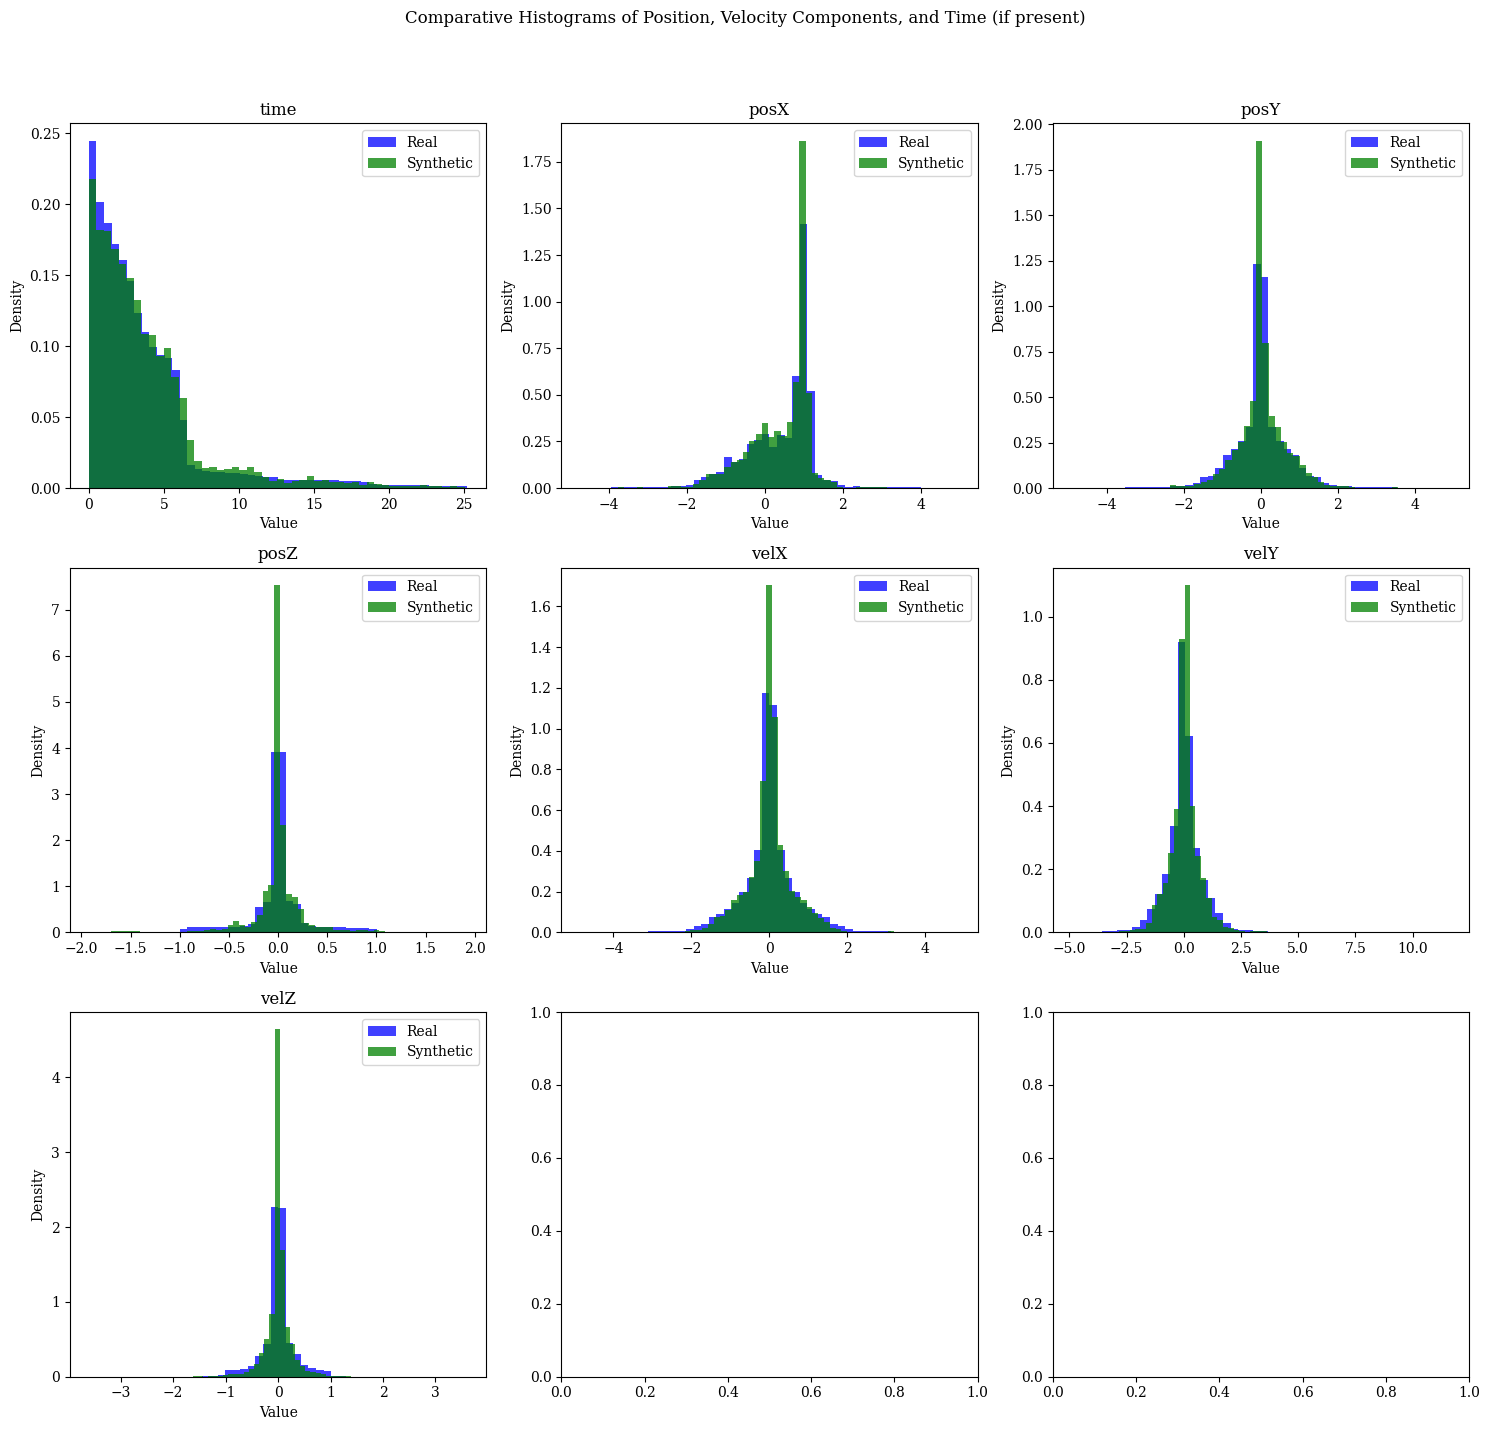

In [23]:
plot_histograms_comparison(data1=data, data2=np.transpose(generation, (0, 2, 1)), label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

Cumulative position error for selected orbits: 989.1844922961809
Average position error per time step: 9.991762548446271


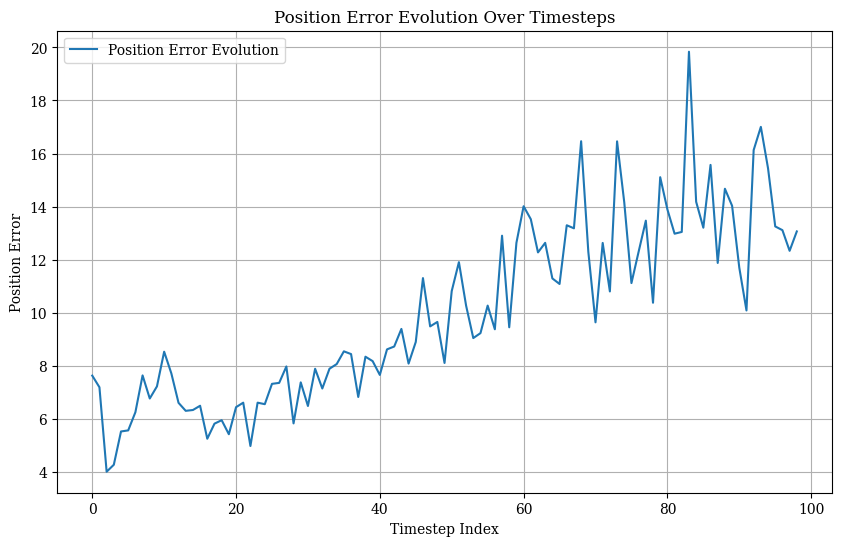

Cumulative velocity error for selected orbits: 2383.7891736674956
Average velocity error per time step: 24.078678521893895


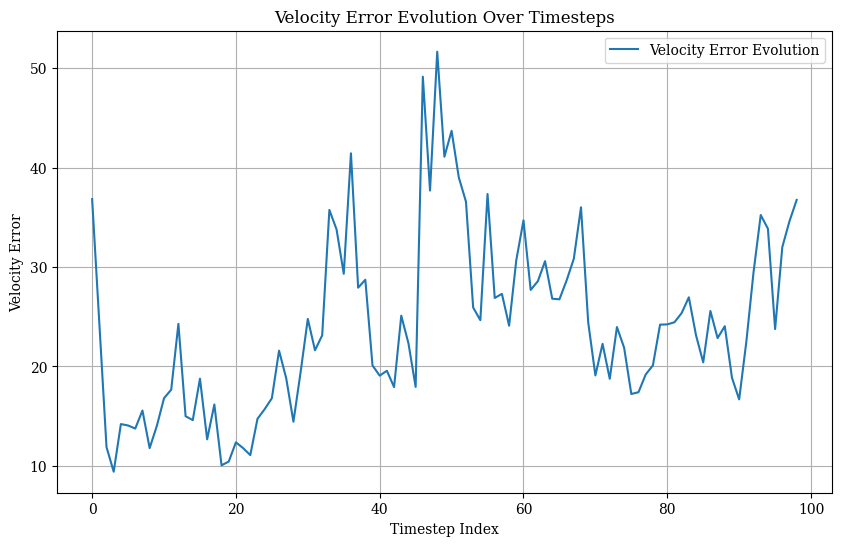

Cumulative energy error for selected orbits: 12012.345536700544
Average energy error per time step: 121.3368236030358


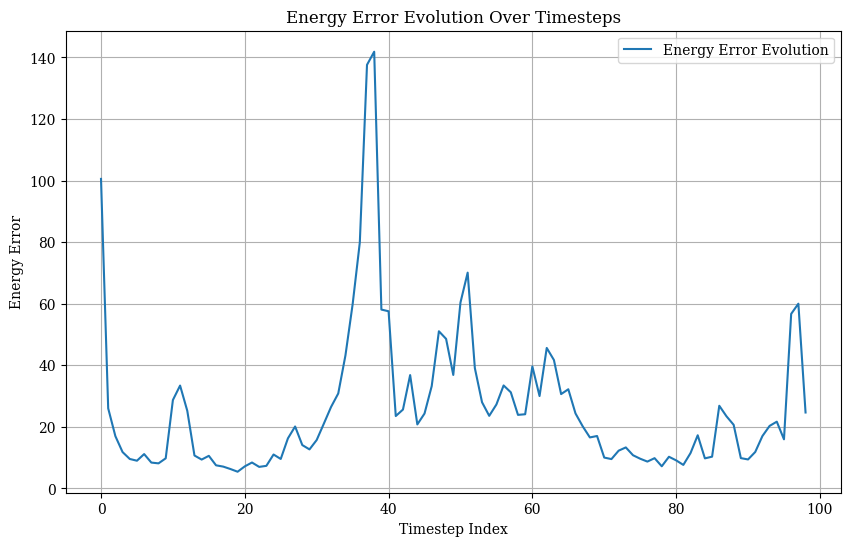

Metrics added to experiment with ID 6 in ../experiments/experiments.json.


In [24]:
if calculate_metrics:
    # add model metrics
    transposed_generation=np.transpose(generation, (0, 2, 1))
    reordered_orbits, order_metrics = reorder_orbits(transposed_generation)
    errors = calculate_errors(reordered_orbits,EM_MU)

    # Add metrics
    add_experiment_metrics(experiments_folder, params=params, metrics={**errors, **order_metrics})

In [ ]:
wandb.finish()